In [3]:
import mne
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import traceback

In [76]:
def create_EDF(edf_in, time_stamps):
    # First import labels
    labels = edf_in.getSignalLabels()
    # Create file:
    edf_out = pyedflib.EdfWriter('test2.edf', len(labels), file_type=pyedflib.FILETYPE_EDFPLUS)
    try:
        # First set the data from the header of the edf file:
        edf_out.setHeader(edf_in.getHeader())
        # f.datarecord_duration gives the value is sec and setDatarecordDuration receives it in units
        # of 10 ms. Therefore: setDatarecordDuration = datarecord_duration*10^6 / 10
        # int(edf_in.datarecord_duration*(100000)))
        edf_out.setDatarecordDuration(int(edf_in.datarecord_duration*100000)) # This actually is used to set the sample frequency
        # Set each channel info:
        # First create an empty list for the data
        channel_data = [np.array([], dtype=float) for chn in range(len(labels))]
        # Sampling rate:
        srate = edf_in.getSampleFrequencies()[0]/edf_in.datarecord_duration
        # Build epochs
        N = edf_in.getNSamples()[0]
        # Time vector:
        t = np.arange(0, N)/srate
        # Relative initial time for epochs
        t_0 = t[np.abs(np.subtract(t,time_stamps[0])).argmin()]
        edf_out.writeAnnotation(0, -1, "Recording starts")
        # Change this for to 2 separate fors. The first should find and store the t_ids and the second one 
        # should iterate across channels
        t_ids = []
        for epoch_id in range(time_stamps.size):
            temp = np.asfortranarray(np.subtract(t,time_stamps[epoch_id]))
            t_init_id = np.abs(temp).argmin() ## CANNOT BE ZERO, change to a not magic #
            t_end_id = int(np.floor(t_init_id+240*srate+1)) # 4 min = 240 s
            t_ids.append((t_init_id, t_end_id))
            # Write annotations
            edf_out.writeAnnotation(t[t_init_id]-t_0, -1, f"Epoch #{epoch_id+1} starts.")
            edf_out.writeAnnotation(t[t_end_id]-t_0, -1, f"Epoch #{epoch_id+1} ends.")
        # Deallocate space in memory
        del t
        for chn in range(len(labels)):
            print(chn)
            signal = edf_in.readSignal(chn)
            for t_id in t_ids:
                channel_data[chn] = np.hstack([channel_data[chn], signal[t_id[0]:t_id[1]], np.zeros(int(60*srate))])
                # Deallocate space in memory
            del signal
        # print(channel_data)
        headers = edf_in.getSignalHeaders()
        for header in headers:
            header['physical_max'] = int(header['physical_max'])
            header['physical_min'] = int(header['physical_min'])
            if len(str(header['physical_max']))>8:
                header['physical_max'] = int(str(header['physical_max'])[0:8])
            if len(str(header['physical_min']))>8:
                header['physical_min'] = int(str(header['physical_min'])[0:8])
        edf_out.setSignalHeaders(headers)
        edf_out.writeSamples(channel_data)
        edf_out.close()
    except Exception:
        traceback.print_exc()
        edf_out.close()

In [4]:
file = "/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/epi_iEEG/ieeg/bids/sub-002/ses-002/ieeg/sub-002_ses-002_task-full_run-01_ieeg.edf"
f = pyedflib.EdfReader(file)

In [5]:
labels = f.getSignalLabels()
print(labels.index('LAFr3'))

2


In [6]:
# n_annot = len(f.readAnnotations()[0])
# annot = np.zeros([n_annot, 3])
annot = f.readAnnotations()
annot = {
    'Onset': annot[0],
    'Duration': annot[1],
    'event': annot[2]
}
annot = pd.DataFrame(annot)
annot.head()

,Onset,Duration,event
0,0.009766,-1.0,Breakout box reconnected.
1,157.500977,-1.0,Patient Event
2,173.684570,-1.0,Patient Event
3,198.474609,-1.0,Patient Event
4,201.696289,-1.0,Patient Event


In [7]:
# Find time stamps where the 'awake trigger' event is happening
id = annot['event'].str.contains('awake trigger', case=False)
time_stamps = annot.Onset.to_numpy()[id]

In [7]:
f.getSignalHeader(123)

{'label': 'C124',
 'dimension': 'uV',
 'sample_rate': 128.0,
 'sample_frequency': 128.0,
 'physical_max': -8711.0,
 'physical_min': 8711.0,
 'digital_max': 32767,
 'digital_min': -32768,
 'prefilter': '',
 'transducer': ''}

In [18]:
len(labels)

148

In [61]:
len(f.getSignalHeaders())

148

In [20]:
# f.getSignalHeaders()[135:148]

In [8]:
srate = (f.getSampleFrequencies()[0]/f.datarecord_duration)
int(np.floor(0+240*srate+1))+int(60*srate)

307201

In [77]:
if time_stamps.size > 0:
    # Here call function
    create_EDF(f, time_stamps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


In [23]:
edf_out.close()

NameError: name 'edf_out' is not defined

In [50]:
f_out.close()

In [17]:
signal = f.readSignal(0)

In [18]:
N = signal.shape[0]
srate = (f.getSampleFrequencies()[0]/f.datarecord_duration)
t = np.arange(0, N)/srate
t_init = np.argmin((np.abs(t-time_stamps[0])))
t_end = int(np.floor(t_init+240*srate+1)) # 4 min = 240 s
epoch = signal[t_init:t_end]

In [28]:
f.datarecord_duration

0.125

In [23]:
t[t_end]-t[t_init]

240.0009765625

In [24]:
t[t_init]

9571.0166015625

In [19]:
np.hstack([epoch, np.zeros(int(60*srate), dtype='int')])

array([-189.94459449, -194.19807736, -214.66796368, ...,    0.        ,
          0.        ,    0.        ])

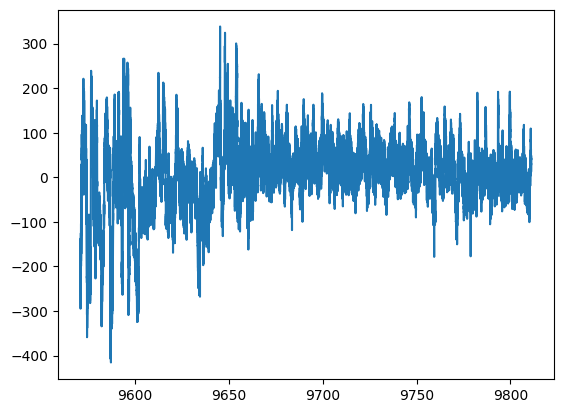

In [20]:
fig, ax = plt.subplots()
ax.plot(t[t_init:t_end], epoch)

In [32]:
f.close()

In [9]:
from EDFlib.edfreader import EDFreader

## Get channels info

In [78]:
file2 = "test2.edf"
f2 = pyedflib.EdfReader(file2)

**Important: pyedf uses int32 to write the values so you have to read them in this format!**

In [85]:
signal2 = f2.readSignal(40).astype('int32')

In [86]:
signal2[len(signal2)-15:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [87]:
len(signal2)

307328

In [82]:
len(f2.getSignalHeaders())

148

In [83]:
annot2 = f2.readAnnotations()
annot2 = {
    'Onset': annot2[0],
    'Duration': annot2[1],
    'event': annot2[2]
}
annot2 = pd.DataFrame(annot2)
annot2.head()

,Onset,Duration,event
0,-0.00007,-1.0,Recording starts
1,-0.00007,-1.0,Epoch #1 starts.
2,240.00093,-1.0,Epoch #1 ends.


In [91]:
N = signal2.shape[0]
srate2 = (f2.getSampleFrequencies()[0]/f2.datarecord_duration)
t = np.arange(0, N)/srate2
t_test = np.argmin((np.abs(t-annot2.Onset.to_numpy()[2])))

In [73]:
f2.datarecord_duration

0.125

In [61]:
t_test

245761

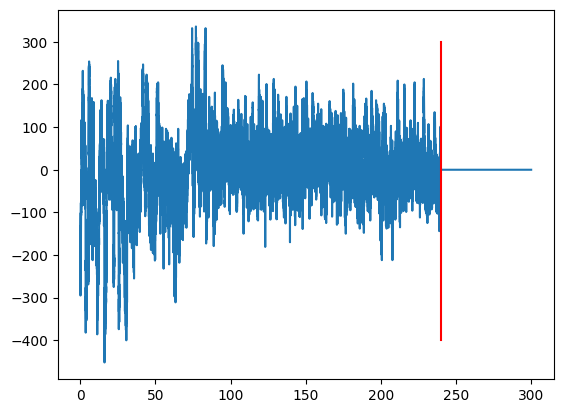

In [92]:
fig, ax = plt.subplots()
ax.plot(t,signal2)
ax.plot([t[t_test], t[t_test]], [-400,300], 'r')

In [93]:
f2.close()

## Extract edf files from path

In [5]:
import os, fnmatch
import re
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [2]:
list_paths = find("*ieeg.edf","/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/epi_iEEG/ieeg/bids/sub-002/")

In [4]:
list_paths[0]

'/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/epi_iEEG/ieeg/bids/sub-002/ses-003/ieeg/sub-002_ses-003_task-full_run-04_ieeg.edf'

In [43]:
pattern = r'sub-\d{3}_ses-\d{3}_task-(.+)_run-\d{2}_ieeg'

In [44]:
caca= re.search(pattern=pattern, string=list_paths[0]).group()
print(caca)

sub-002_ses-003_task-full_run-04_ieeg
